<a href="https://colab.research.google.com/github/BSteiner1/Adversarial-Examples/blob/main/Notebooks/AdvExCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Download data

In [2]:
# Load Fashion MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:02<00:00, 11499491.91it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 213621.77it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3783013.05it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22100590.58it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Class label dictionary

In [3]:
labels_dict = {0 : "T-shirt/top",
               1 : "Trouser",
               2 : "Pullover",
               3 : "Dress",
               4 : "Coat",
               5 : "Sandal",
               6 : "Shirt",
               7 : "Sneaker",
               8 : "Bag",
               9 : "Ankle boot"}

### Create model

In [4]:
# Define the CNN model using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(3136, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [5]:
# Instantiate the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

### Calculate model accuracy

In [6]:
def accuracy(model, images, test_loader):

  # Evaluation
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = correct / total

  return accuracy

### Train Model

In [7]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

    acc = accuracy(model, images, test_loader)

    print(f'Test Accuracy: {acc * 100:.2f}%')

Epoch [1/10], Loss: 0.3317437171936035
Test Accuracy: 89.23%
Epoch [2/10], Loss: 0.18958304822444916
Test Accuracy: 89.89%
Epoch [3/10], Loss: 0.23715651035308838
Test Accuracy: 90.80%
Epoch [4/10], Loss: 0.07966965436935425
Test Accuracy: 91.57%
Epoch [5/10], Loss: 0.22598052024841309
Test Accuracy: 91.67%
Epoch [6/10], Loss: 0.07238070666790009
Test Accuracy: 90.80%
Epoch [7/10], Loss: 0.03992364928126335
Test Accuracy: 91.74%
Epoch [8/10], Loss: 0.03903866931796074
Test Accuracy: 91.61%
Epoch [9/10], Loss: 0.06419950723648071
Test Accuracy: 90.82%
Epoch [10/10], Loss: 0.03465178608894348
Test Accuracy: 91.30%


### Save model

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [133]:
# Save the entire model
torch.save(model.state_dict(), '/content/drive/MyDrive/MA498/CNN_model.pth')

### Get pre-trained model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MA498/CNN_model.pth'))
model.eval()  # Set the model to evaluation mode

Sequential(
  (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=256, out_features=64, bias=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=32, bias=True)
  (13): ReLU()
  (14): Linear(in_features=32, out_features=10, bias=True)
)

### Adversarial Examples

In [10]:
def adversarial_example_class(image, epsilon):

  gradient = image.grad.data

  # Create adversarial image
  adversarial_example = image + (epsilon * gradient.sign())
  adversarial_output = model(adversarial_example.unsqueeze(0))
  adversarial_prediction = torch.argmax(adversarial_output).item()

  return adversarial_prediction

In [11]:
def gen_adversarial_example(image, model):

  # Keep gradients
  image.requires_grad = True

  # Original image class
  output = model(image.unsqueeze(0))
  original_prediction = torch.argmax(output).item()

  # Calculate the loss
  loss = F.cross_entropy(output, torch.tensor([original_prediction]))
  model.zero_grad()

  # Backward pass to compute the gradient of the loss with respect to the input image
  loss.backward()
  gradient = image.grad.data

  # Increment epsilon until classification is wrong
  epsilon = 0
  while adversarial_example_class(image, epsilon) == original_prediction:
    epsilon += 0.01

  adversarial_example = image + (epsilon * gradient.sign())

  return np.round(epsilon, 2), adversarial_example

In [123]:
def plot_adv_example(image, model):

    # Original Prediction
    output = model(image.unsqueeze(0))
    original_prediction = torch.argmax(output).item()

    # Get the confidence associated with the original prediction
    image_probabilities = F.softmax(output, dim=1)
    confidence = image_probabilities[0, original_prediction].item()

    # Adversarial prediction
    eps, adversarial_image = gen_adversarial_example(image, model)

    # Verify the model's prediction on the adversarial example
    adversarial_output = model(adversarial_image.unsqueeze(0))
    adversarial_prediction = torch.argmax(adversarial_output).item()

    # Get the confidence associated with the adversarial prediction
    adv_image_probabilities = F.softmax(adversarial_output, dim=1)
    adv_confidence = adv_image_probabilities[0, adversarial_prediction].item()

    # Convert tensor to numpy arrays
    original_image_np = image.squeeze().detach().numpy()
    adversarial_image_np = adversarial_image.squeeze().detach().numpy()

    # Display the original and adversarial images side by side
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    plt.subplots_adjust(wspace=1, right=0.5)

    # Original Image
    axes[0].imshow(original_image_np, cmap='gray')
    axes[0].set_title('Original')
    axes[0].set_xlabel(f'{labels_dict[original_prediction]}\n{confidence*100:.1f}%')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Noise
    noise = adversarial_image - image
    grad = noise/eps
    noise_output = model(grad.unsqueeze(0))
    noise_prediction = torch.argmax(noise_output).item()
    noise_np = noise.squeeze().detach().numpy()

    # Get the confidence associated with the noise prediction
    noise_probabilities = F.softmax(noise_output, dim=1)
    noise_confidence = noise_probabilities[0, noise_prediction].item()

    axes[1].imshow(noise_np, cmap='gray')
    axes[1].set_title('Noise')
    axes[1].set_xlabel(f'{labels_dict[noise_prediction]}\n{noise_confidence*100:.1f}%')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Adversarial Example
    axes[2].imshow(adversarial_image_np, cmap='gray')
    axes[2].set_title('Adversarial')
    axes[2].set_xlabel(f'{labels_dict[adversarial_prediction]}\n{adv_confidence*100:.1f}%')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    # Add a simple plus sign between the images
    axes[0].text(1.58, 0.5, '+   ' + str(eps) + ' x', ha="center", va="center", fontsize=10, transform=axes[0].transAxes)
    #axes[0].text(1.8, 0.5, '(' + str(eps) + ') x ', ha="center", va="center", fontsize=2, transform=axes[0].transAxes)
    axes[1].text(1.5, 0.5, '=', ha="center", va="center", fontsize=20, transform=axes[1].transAxes)

    plt.show()

    #print("Epsilon: ", eps)

In [131]:
indices = [310, 1900, 2320, 2500]

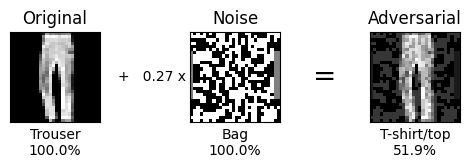

--------------------------------------------------------------


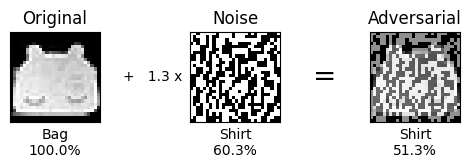

--------------------------------------------------------------


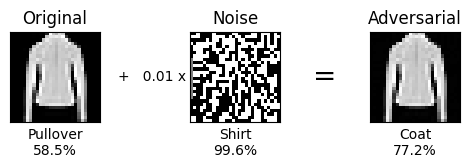

--------------------------------------------------------------


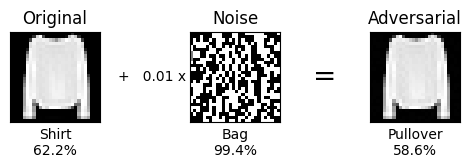

--------------------------------------------------------------


In [136]:
for i in indices:
  plot_adv_example(test_dataset[i][0], model)
  print("--------------------------------------------------------------")